<h2>Imports</h2>

In [1]:
import os
import numpy as np
import torch
from corpus import Corpus, CornellMovieCorpus, Vocabulary
from rnn import GRUEncoder, GRUDecoder, AttentionEncoder, AttentionDecoder
from torch import optim
import torch.nn as nn
from matplotlib import pyplot as plt
from datetime import datetime
import random
from torch.utils.data import DataLoader as DataLoader
from metrics import show_loss
from utils import  evaluate, maskNLLLoss, CrossEntropyLoss

<h2>Parameter Settings</h2>

In [2]:
random.seed(77)
EXPERIMENT_NAME = "v1_exp1"
SIZEOF_EMBEDDING = 128
NUMBER_OF_EPOCHS = 1
BATCH_SIZE = 5
TEACHER_FORCING = 1
TEACHER_FORCING_DECAY = 0
PROGRESS_INTERVAL = 100
EVAL_INTERVAL = 1000
LEARNING_RATE = 1e-03
BACKPROPAGATE_INTERVAL = 1
DROPOUT = 0.1
BIDIRECTIONAL = True
NUMBER_OF_LAYERS = 2
CRITERION = CrossEntropyLoss
USE_ATTENTION = False

<h2>Use the GPU if present</h2>

In [3]:
device = torch.device('cpu')
if (torch.cuda.is_available()):
   device = torch.device('cuda')
print(device)


cuda


<h2>Create a Cornell Movie Corpus </h2>

In [4]:
corpus = CornellMovieCorpus(device=device, data_directory = "../data",
                            limit_pairs=True, limit_words = True, max_seq_length=10, min_word_count=3)

Loading movie lines...
Creating vocabulary...
Converting conversation line numbers to text...
Creating exchange pairs


<h2>Let's look at some data</h2>

In [5]:
lines = list(corpus.movie_lines.items())
print(len(lines), "movie lines loaded")

distinct_lines = [line[1]["prepped_text"] for line in lines]
print(len(set(distinct_lines)), "distinct movie lines exist")

line_lengths = [len(line[1]["prepped_text"].split(" ")) for line in lines]
print(sum(line_lengths)/len(line_lengths), "Average number of tokens in a line")


print(len(corpus.movie_convos), "conversations loaded")

print(len(corpus.conversations), "exchange pairs")

304713 movie lines loaded
257093 distinct movie lines exist
11.197448090498272 Average number of tokens in a line
83097 conversations loaded
88222 exchange pairs


<h2>Create Encoders and Decoders</h2>

In [6]:
sizeof_vocab = corpus.vocabulary.len
#If BIDIRECTIONAL, then the number of layers in the Decoder must be twice the number in the Encoder
if BIDIRECTIONAL: 
    decoder_layers = 2 * NUMBER_OF_LAYERS
else:
    decoder_layers = NUMBER_OF_LAYERS

if USE_ATTENTION:   
    encoder = AttentionEncoder(sizeof_vocab = sizeof_vocab, sizeof_embedding = SIZEOF_EMBEDDING, num_layers = NUMBER_OF_LAYERS,
                               bidirectional=BIDIRECTIONAL, dropout=DROPOUT)
    decoder = AttentionDecoder(sizeof_embedding=SIZEOF_EMBEDDING, sizeof_vocab=sizeof_vocab, num_layers=decoder_layers,dropout=DROPOUT)
else:
    encoder = GRUEncoder(sizeof_embedding=SIZEOF_EMBEDDING, sizeof_vocab=sizeof_vocab, num_layers = NUMBER_OF_LAYERS, bidirectional=BIDIRECTIONAL, dropout=DROPOUT)
    decoder = GRUDecoder(sizeof_embedding= SIZEOF_EMBEDDING, sizeof_vocab = sizeof_vocab, num_layers = decoder_layers, dropout=DROPOUT)

# embedding = nn.Embedding(sizeof_vocab, SIZEOF_EMBEDDING)
# # Initialize encoder & decoder models
# #encoder = EncoderRNN(SIZEOF_EMBEDDING, embedding, 1, 0)
# decoder = LuongAttnDecoderRNN("dot", embedding, SIZEOF_EMBEDDING, sizeof_vocab, 1, 0)

encoder.to(device)
decoder.to(device)

GRUDecoder(
  (embedding): Embedding(49048, 128)
  (gru): GRU(128, 128, num_layers=4, dropout=0.1)
  (out): Linear(in_features=128, out_features=49048, bias=True)
)

<h2>Let's setup our trainer</h2>

In [7]:
encoder_optimizer = optim.Adam(encoder.parameters(),lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(),lr=LEARNING_RATE)

#criterion = NegativeLLLoss
#criterion = nn.CrossEntropyLoss(ignore_index = Vocabulary.PAD_index)



#ref: https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3?u=ptrblck
dataloader = DataLoader(corpus, batch_size=BATCH_SIZE,shuffle=True, collate_fn=Corpus.collate_convos)

batch_type = "Exchange Pair"

<h2>Train</h2>

In [8]:
epoch_loss = 0
start_time = datetime.now()
training_loss = []
total_sequences = 0
interval_seq_count = 0


for epoch in range(NUMBER_OF_EPOCHS):
    epoch_loss = 0
    processed_total_batches = 0
    batch_counter = 0

    interval_loss = 0
    propagation_loss = 0

    #Let's train on the entire dataset
    for idx, batch in enumerate(dataloader):
        #Each batch contains a batch_size number of exchange pairs
        
        teacher_forcing = False
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        #Let's extract the data from each batch

        #The Q and Q tensors
        Q_tensors = torch.stack([batch[i][1]["Q"] for i in range(len(batch))]) #shape(batch_size, 1, seq_len) #1 represents 1 exchange pair
        A_tensors= torch.stack([batch[i][1]["A"] for i in range(len(batch))]) #shape(batch_size, 1, seq_len)  #1 represents 1 exchange pair

        #The masks to mask the padded sequences
        Q_masks = torch.stack([batch[i][1]["Q_mask"] for i in range(len(batch))])  # shape(batch_size, 1, seq_len) #1 represents 1 exchange pair
        A_masks = torch.stack([batch[i][1]["A_mask"] for i in range(len(batch))])  # shape(batch_size, 1, seq_len)  #1 represents 1 exchange pair

        #Get the length of each sequence.
        Q_lens = [batch[i][1]["Q_len"] for i in range(len(batch))]
        A_lens = [batch[i][1]["A_len"] for i in range(len(batch))]

        #Remove the 1 in each of the tensors i.e. [batch_size,1,seq_length]
        Q_tensors = Q_tensors.squeeze(1)
        A_tensors = A_tensors.squeeze(1)

        #Get the batch size and sequence length
        batch_size = A_tensors.shape[0] #Number of sequences in the target
        seq_length = A_tensors.shape[1] #All sequences are fixed length
        
        #We set seq_length to the length of the longest sequence so that
        # in calculating the loss we do not pass a tensor full of padding
        # tokens as this returns a nan
        seq_length = max(A_lens)

        #Transpose to tensors are now seq_length, batch_size
        Q_tensors = torch.transpose(Q_tensors,0,1)
        A_tensors = torch.transpose(A_tensors,0,1)

        Q_masks = torch.transpose(Q_masks, 0, 1)
        A_masks = torch.transpose(A_masks, 0, 1)

        #Encode the batch. The encoder accepts an input of shape (seq_length,batch_size)
        encoder_output, encoder_hidden = encoder(Q_tensors, Q_lens) # encoder_output: (max_seq_len, batch_size, hidden_size), encoder_hidden: (1, batch_size, hidden_size)

        # At the start, the first input to the decoder is the SOS token
        # Create a batch of SOS tensors
        decoder_input = torch.tensor([[corpus.vocabulary.SOS_index for _ in range(batch_size)]],
                                     dtype=torch.int64, device=device)

        #The initial hidden input to the decoder is the last hidden of the encoder.
        decoder_hidden = encoder_hidden
        
        loss = 0
        interval_seq_count+=batch_size
        total_sequences+=batch_size

        #If we are using teach forcing then the decoder_hidden is the 
        if random.random() < TEACHER_FORCING: teacher_forcing = True
        
        for i in range(seq_length):
            
            #Get the decoder output and hidden state for the
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output) #decoder_output (1, batch_size, sizeof_vocab), decoder_hidden (batch_size, sizeof_hidden)

            #decoder_output = decoder_output.squeeze(0)
            # calculate the loss by comparing with the tensor of the target
            target = A_tensors[i,:]

            #loss += criterion(decoder_output,target).mean()

            mask_loss, nTotal = CRITERION(decoder_output, target, A_masks[i,:], device)
            loss+=mask_loss

            #Get the top prediction for each batch
            decoder_input = decoder_output.topk(k=1, dim=1).indices

            #Change the view to (1, batch_size)
            decoder_input = decoder_input.view(1,-1)
            
            #if teacher forcing then the target is fed in as the input
            #change view to 1, batch_size
            if teacher_forcing: decoder_input = target.view(1,-1)
        
        propagation_loss += loss
        sequence_loss = loss.item()/seq_length
        interval_loss += sequence_loss


        TEACHER_FORCING = max(0,TEACHER_FORCING - (TEACHER_FORCING*TEACHER_FORCING_DECAY))
        
        if batch_counter%BACKPROPAGATE_INTERVAL == 0:
            propagation_loss.backward()
            # ref: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot%20tutorial
            _ = nn.utils.clip_grad_norm_(encoder.parameters(), 50)
            _ = nn.utils.clip_grad_norm_(decoder.parameters(), 50)
                
            encoder_optimizer.step()
            decoder_optimizer.step()
            propagation_loss = 0

        if batch_counter%PROGRESS_INTERVAL == 0 and batch_counter:
            #Calculate the average sequence loss over the interval
            end_time = datetime.now()
            timediff = end_time - start_time
            timediff = timediff.seconds
            print("Batch#: {0:1d}, Total Sequences Processed: {1:1d}, Loss {3:.6f}, Duration {4:d} seconds, Teacher Forcing {5:.6f}".format(batch_counter, total_sequences, interval_seq_count, interval_loss/interval_seq_count, timediff, TEACHER_FORCING))
            start_time = datetime.now()
            interval_loss = 0
            interval_seq_count = 0

        if batch_counter%EVAL_INTERVAL == 0 and batch_counter!=0:
            evaluate("Hi! how are you?",encoder,decoder,corpus, device)

        training_loss.append([batch_counter,sequence_loss])
        batch_counter += 1

Batch#: 100, Total Sequences Processed: 505, Loss 1.574394, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 200, Total Sequences Processed: 1005, Loss 1.279288, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 300, Total Sequences Processed: 1505, Loss 1.262178, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 400, Total Sequences Processed: 2005, Loss 1.224592, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 500, Total Sequences Processed: 2505, Loss 1.218410, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 600, Total Sequences Processed: 3005, Loss 1.192826, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 700, Total Sequences Processed: 3505, Loss 1.174969, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 800, Total Sequences Processed: 4005, Loss 1.222198, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 900, Total Sequences Processed: 4505, Loss 1.206722, Duration 1 seconds, Teacher Forcing 1.000000
Batch#: 1000, Total Sequences Processed: 5005, 

<h2>Save and print results</h2>

In [9]:
data_file = EXPERIMENT_NAME + ".csv"
np.savetxt(data_file,training_loss,delimiter=",")
torch.save(encoder.state_dict(), EXPERIMENT_NAME + "_encoder.dict")
torch.save(decoder.state_dict(), EXPERIMENT_NAME + "_decoder.dict")

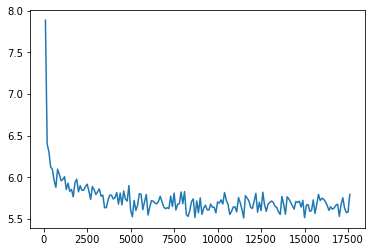

In [10]:
show_loss(data_file,100)

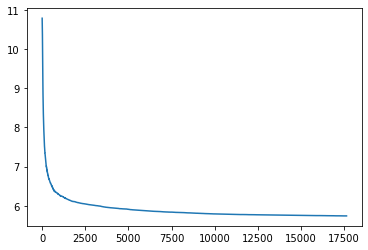

In [11]:
def show_average_accumulated_loss(data_file):
    training_loss = np.genfromtxt(data_file,delimiter=",")
    average_loss = []
    for i in range(1,len(training_loss)):
        #print(sum(training_loss[i-interval:i,1])/interval)
        average_loss.append([i, sum(training_loss[:i,1])/i] )
    average_loss = np.array(average_loss)
    plt.plot(average_loss[:, 0], average_loss[:, 1])
    plt.show()
show_average_accumulated_loss(data_file)

In [13]:
txt = ""
while txt != "Bye!":
    txt = input()
    evaluate(txt,encoder,decoder,corpus, device)

KeyboardInterrupt: Interrupted by user